In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import scipy.stats as stats

## Method 1
Define class Cell to keep track of mutations, assign unique labels to each of them.

In [2]:
class Cell:
    def __init__(self, mutations=None):
        if mutations is None:
            self.mutations = []
        else:
            self.mutations = mutations[:]

    def mutate(self, mutation_rate):
        # Sample the number of new mutations from a Poisson distribution
        num_mutations = int(np.random.poisson(mutation_rate))
        # Assign unique mutation identifiers
        new_mutations = [f"m{random.randint(initial_mutations, int(1e8))}" for _ in range(num_mutations)]
        self.mutations.extend(new_mutations)
        return new_mutations

def gillespie_branching_process_with_mutations(initial_population, birth_rate, death_rate, mutation_rate, max_cells, initial_mutations):
    """
    Perform a Gillespie simulation of a branching process with detailed mutation tracking.

    Parameters:
        initial_population (int): The initial number of individuals.
        birth_rate (float): The birth rate (lambda).
        death_rate (float): The death rate (mu).
        mutation_rate (float): The mean number of mutations per birth event.
        max_cells (float): The maximum number of cells in the population.
        initial_mutations (int): The number of initial mutations in the first individual.

    Returns:
        times (list of float): The times at which events occur.
        populations (list of int): The population sizes at each event time.
        mutation_history (list of list of str): The mutation history for each individual.
    """

    # Initialize the state
    population = []
    init_mutations = [f"m{i}" for i in range(initial_mutations)]
    for _ in range(initial_population):
        population.append(Cell(mutations=init_mutations)) # First individual with initial mutations
    time = 0.0

    # Lists to store times, population sizes, and mutation history
    times = [time]
    populations = [initial_population]
    mutation_history = [init_mutations]

    while len(population) < max_cells and len(population) > 0:
        # Calculate the rates for birth and death events
        birth_rate_total = birth_rate * len(population)
        death_rate_total = death_rate * len(population)
        total_rate = birth_rate_total + death_rate_total

        # Sample the time to the next event
        time_to_next_event = np.random.exponential(1 / total_rate)
        time += time_to_next_event

        # Determine which event occurs (birth or death)
        if np.random.rand() < birth_rate_total / total_rate:
            # Birth event
            parent = random.choice(population)
            offspring_1 = Cell(parent.mutations)
            offspring_1.mutate(mutation_rate)
            offspring_2 = Cell(parent.mutations)
            offspring_2.mutate(mutation_rate)
            population.remove(parent)
            population.append(offspring_1)
            population.append(offspring_2)
        else:
            # Death event
            victim = random.choice(population)
            population.remove(victim)

        # Record the time and population size
        times.append(time)
        populations.append(len(population))

        # Record the mutation history
        current_mutations = [ind.mutations for ind in population]
        mutation_history.append(current_mutations)

    return times, populations, mutation_history

# Parameters
initial_population = 1
birth_rate = 10.0
death_rate = 0.0
mutation_rate = 50.0  # Mean number of mutations per birth event
# max_time = 17.0
max_cells = 10000
initial_mutations = 1000

# Run the Gillespie simulation
times, populations, mutation_history = gillespie_branching_process_with_mutations(initial_population, birth_rate, death_rate, mutation_rate, max_cells, initial_mutations)


In [ ]:
# Plot the population size over time
plt.figure(figsize=(10, 6))
plt.step(times, populations, where='post', label='Population size')
plt.xlabel('Time')
plt.ylabel('Population size')
plt.title('Gillespie Simulation of a Branching Process with Mutations')
plt.grid(True)
plt.legend()

In [3]:
# Analyze and plot the distribution of mutation frequencies
mutation_count = {}
for history in mutation_history[-1]:
    for mutation in history:
        if mutation not in mutation_count:
            mutation_count[mutation] = 0
        mutation_count[mutation] += 1

mutation_frequencies = list(mutation_count.values())

# Normalise the frequencies
frequencies = [x/populations[-1] for x in mutation_frequencies]


# If ploidy is 2, divide the frequencies by 2
frequencies = [x/2 for x in frequencies]

# Only keep mutations with a frequency above 2%
# frequencies = [freq for freq in frequencies if freq >= 0.02]

In [ ]:
# Plot the distribution of mutation frequencies
plt.figure(figsize=(10, 6))
plt.hist(frequencies, bins = 200)
plt.xlabel('Frequency of Mutation')
plt.ylabel('Frequency')
plt.title('Number of Mutations')
plt.grid(True)
plt.show()

In [4]:
# Create a list with unique values of frequencies and a list with the respective counts
mutation_counts = [1]
unique_frequencies = [frequencies[0]]
for i in range(len(frequencies)-1):
    if frequencies[i+1] != frequencies[i]:
        mutation_counts.append(1)
        unique_frequencies.append(frequencies[i+1])
    if frequencies[i+1] == frequencies[i]:
        mutation_counts[-1] = mutation_counts[-1] + 1

In [5]:
len(unique_frequencies) == len(mutation_counts)

True

## Method 2
Since the frequency of a mutation does not change in time, store the frequency once the mutation appears in the population.

In [16]:
def gillespie_branching_process_with_mutations(initial_population, birth_rate, death_rate, mutation_rate, max_cells, initial_mutations, ploidy):
    """
    Perform a Gillespie simulation of a branching process with detailed mutation tracking.

    Parameters:
        initial_population (int): The initial number of individuals.
        birth_rate (float): The birth rate (lambda).
        death_rate (float): The death rate (mu).
        mutation_rate (float): The mean number of mutations per birth event.
        max_time (float): The maximum simulation time.

    Returns:
        times (list of float): The times at which events occur.
        populations (list of int): The population sizes at each event time.
        mutation_history (list of list of str): The mutation history for each individual.
    """

    # Initialize the state
    population = initial_population
    time = 0.0

    # Lists to store times, population sizes, and mutation history
    times = [time]
    populations = [population]
    mutation_frequencies = [0.5 for _ in range(initial_mutations)]

    while population < max_cells and population > 0:
        # Calculate the rates for birth and death events
        birth_rate_total = birth_rate * population
        death_rate_total = death_rate * population
        total_rate = birth_rate_total + death_rate_total

        # Sample the time to the next event
        time_to_next_event = np.random.exponential(1 / total_rate)
        time += time_to_next_event

        # Determine which event occurs (birth or death)
        if np.random.rand() < birth_rate_total / total_rate:
            # Birth event
            population += 1
            new_mutations = np.random.poisson(mutation_rate)
            if new_mutations > 0:
                new_frequency = 1.0/(population*ploidy)
            for _ in range(new_mutations):
                mutation_frequencies.append(new_frequency)
        else:
            # Death event
            population -= 1

        # Record the time and population size
        times.append(time)
        populations.append(population)
        

    return times, populations, mutation_frequencies

# Parameters
initial_population = 1
birth_rate = 10.0
death_rate = 0.0
mutation_rate = 50.0  # Mean number of mutations per birth event
max_time = 1.0
max_cells = 10000
initial_mutations = 50
ploidy = 2

# Run the Gillespie simulation
times, populations, mutation_frequencies = gillespie_branching_process_with_mutations(initial_population, birth_rate, death_rate, mutation_rate, max_cells, initial_mutations, ploidy)


In [17]:
# Keep only mutations with a frequency above 2%
mutation_frequencies = [freq for freq in mutation_frequencies if freq >= 0.02]
len(mutation_frequencies)

1243

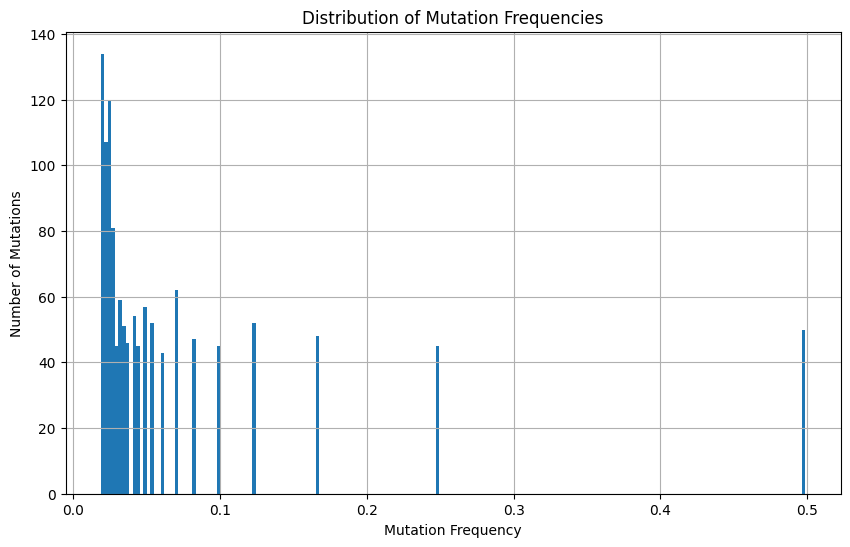

In [18]:
# Plot the distribution of mutation frequencies
plt.figure(figsize=(10, 6))
counts, bin_edges, patches= plt.hist(mutation_frequencies, bins=200, align='left')
plt.xlabel('Mutation Frequency')
plt.ylabel('Number of Mutations')
plt.title('Distribution of Mutation Frequencies')
plt.grid(True)
plt.show()

In [6]:
# Export the histogram data to a CSV file using pandas
freq_histo = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
df = pd.DataFrame({'frequency': freq_histo, 'count': counts})
df

,frequency,count
0,0.020100,77.0
1,0.020301,0.0
2,0.020501,0.0
3,0.020702,0.0
4,0.020903,104.0
...,...,...
2388,0.499097,0.0
2389,0.499298,0.0
2390,0.499499,0.0
2391,0.499699,0.0


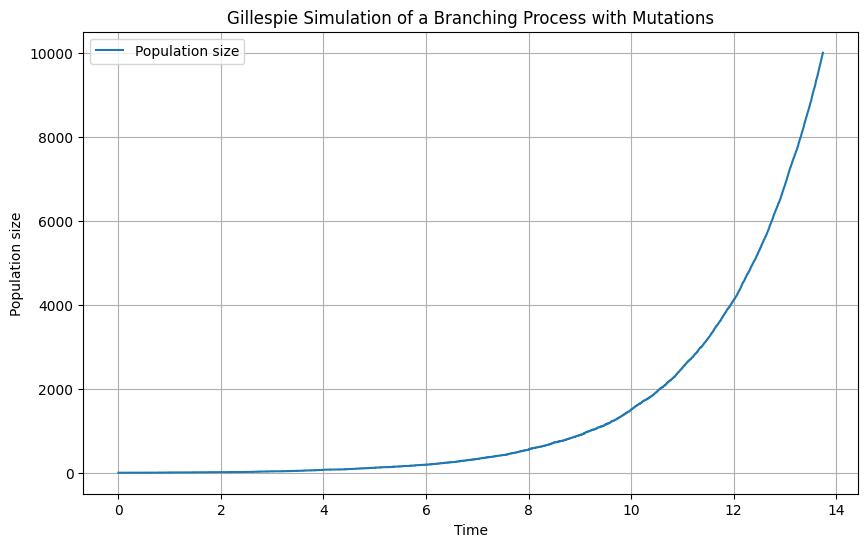

In [263]:
plt.figure(figsize=(10, 6))
plt.step(times, populations, where='post', label='Population size')
plt.xlabel('Time')
plt.ylabel('Population size')
plt.title('Gillespie Simulation of a Branching Process with Mutations')
plt.grid(True)
plt.legend()

## Sampling noise
Add (beta-)binomial noise the simulation data: sample the sequencing depth from a binomial with probability of success $p = D/N$ and $N$ trials, where $D$ is the desired depth and $N$ the tumour size, then sample the observed frequencies from a beta-binomial with probability of success given by the true VAF (which is 0.5 for a diploid tumour in the neutral case, with no subclones under selections) divided by the tumour size, number of trials equal to the sampled sequencing depth and over-dispersion parameter $\rho$.

In [7]:
def betabinomial(x,n,a,b):
    from scipy.special import comb
    from scipy.special import beta
    return comb(n, x) * beta(x+a, n-x+b) / beta(a, b)

In [6]:
# Add binomial noise to simulated VAFs
D = 200
N = max_cells

obs_vaf = []
# obs_counts = []

for i in range(len(unique_frequencies)):
    # Sample the sequencing depth
    seq_depth = np.random.binomial(n = N, p = D/N)
    
    # Sample the observed VAFs
    reads = stats.binom.rvs(n = seq_depth, p = unique_frequencies[i], size = mutation_counts[i])
    vaf = [x/seq_depth for x in reads]
    # counts = [stats.binom.pmf(k = f, n = seq_depth, p = unique_frequencies[i])*seq_depth for f in reads]
    
    for j in range(len(vaf)):
        obs_vaf.append(vaf[j])
        # obs_counts.append(counts[j])
    
    
# Remove frequencies with less than 2% frequency
obs_vaf_filtered = [x for x in obs_vaf if x >= 0.02]

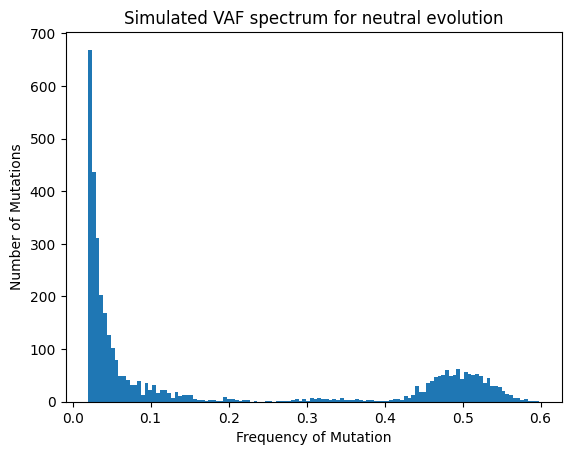

In [98]:
plt.hist(obs_vaf_filtered, bins = 120)
plt.xlabel('Allelic Frequency')
plt.ylabel('Number of Mutations')
plt.title('Simulated VAF spectrum for neutral evolution')
plt.show()

## ABC

In [59]:
def vaf_simulator_neutral(initial_population, birth_rate, death_rate, mutation_rate, max_cells, initial_mutations, coverage, cutoff, ploidy):

    # Run the Gillespie simulation
    times, populations, mutation_history = gillespie_branching_process_with_mutations(initial_population, birth_rate, death_rate, mutation_rate, max_cells, initial_mutations)
        
    # Compute mutation frequencies
    mutation_count = {}
    for history in mutation_history[-1]:
        for mutation in history:
            if mutation not in mutation_count:
                mutation_count[mutation] = 0
            mutation_count[mutation] += 1

    mutation_frequencies = list(mutation_count.values())

    # Normalise the frequencies
    frequencies = [x/populations[-1] for x in mutation_frequencies]

    # Divide the frequencies by the ploidy
    frequencies = [x/ploidy for x in frequencies]
        
    # Create a list with unique values of frequencies and a list with the respective counts
    mutation_counts = [1]
    unique_frequencies = [frequencies[0]]
    for i in range(len(frequencies)-1):
        if frequencies[i+1] != frequencies[i]:
            mutation_counts.append(1)
            unique_frequencies.append(frequencies[i+1])
        if frequencies[i+1] == frequencies[i]:
            mutation_counts[-1] = mutation_counts[-1] + 1
            
    # Add binomial noise to simulated VAFs
    obs_vaf = []

    for i in range(len(unique_frequencies)):
        # Sample the sequencing depth
        seq_depth = np.random.binomial(n = max_cells, p = coverage/max_cells)
        # Sample the observed VAFs
        reads = stats.binom.rvs(n = seq_depth, p = unique_frequencies[i], size = mutation_counts[i])
        vaf = [x/seq_depth for x in reads]
        for j in range(len(vaf)):
            obs_vaf.append(vaf[j])
            
    # Remove frequencies lower than the cutoff
    obs_vaf_filtered = [x for x in obs_vaf if x >= cutoff]

    return obs_vaf_filtered

In [159]:
# Parameters
initial_population = 1
birth_rate = 10.0
death_rate = 0.0

max_cells = 10000
initial_mutations = 1000
coverage = 200
ploidy = 2
cutoff = 0.02

In [168]:
iterations = 300
mutation_rate = 50.0
target = vaf_simulator_neutral(initial_population, birth_rate, death_rate, mutation_rate, max_cells, initial_mutations, coverage, cutoff, ploidy)

params = []
for i in range(iterations):
    theta = np.random.uniform(10, 100)
    sim = vaf_simulator_neutral(initial_population, birth_rate, death_rate, theta, max_cells, initial_mutations, coverage, cutoff, ploidy)

    distance = stats.kstest(sim, target)[0]
    if distance < 0.03:
        params.append(theta)

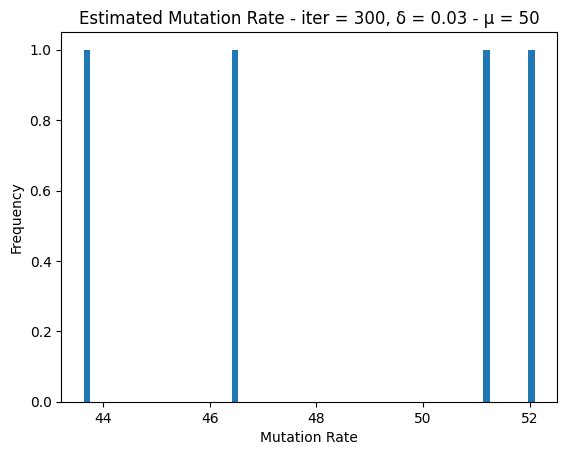

In [148]:
# Threshold 0.03 - 300 iterations - mu = 50 - range(10, 100)
plt.hist(params, bins=70)
plt.xlabel('Mutation Rate')
plt.ylabel('Frequency')
plt.title('Estimated Mutation Rate - iter = 300, δ = 0.03 - μ = 50')
plt.show()

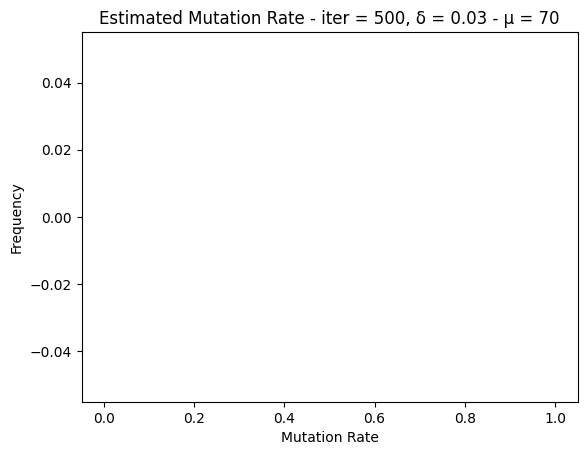

In [145]:
# Threshold 0.03 - 300 iterations - mu = 30
plt.hist(params, bins=70)
plt.xlabel('Mutation Rate')
plt.ylabel('Frequency')
plt.title('Estimated Mutation Rate - iter = 500, δ = 0.03 - μ = 70')
plt.show()

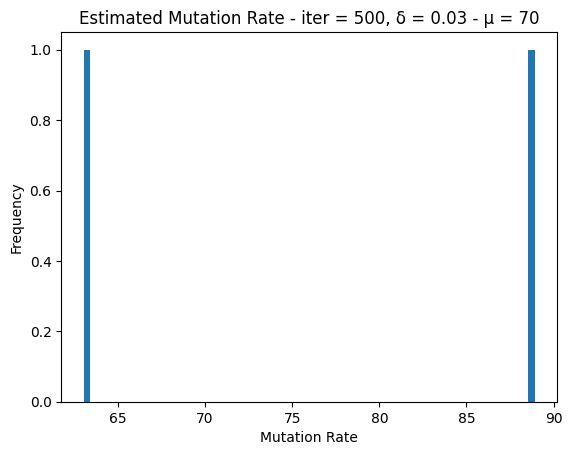

In [143]:
# Threshold 0.03 - 500 iterations - mu = 70
plt.hist(params, bins=70)
plt.xlabel('Mutation Rate')
plt.ylabel('Frequency')
plt.title('Estimated Mutation Rate - iter = 500, δ = 0.03 - μ = 70')
plt.show()

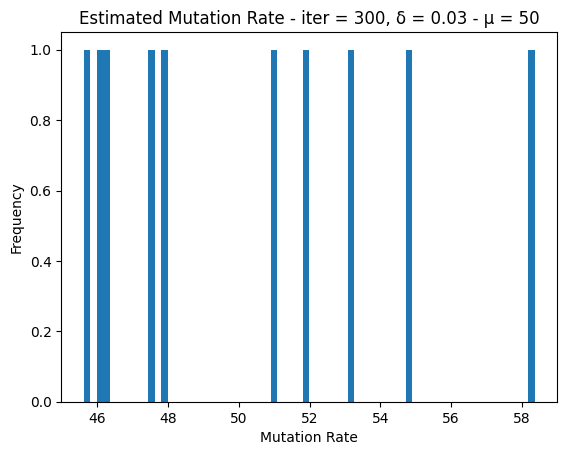

In [139]:
# Threshold 0.03 - 500 iterations 
plt.hist(params, bins=70)
plt.xlabel('Mutation Rate')
plt.ylabel('Frequency')
plt.title('Estimated Mutation Rate - iter = 300, δ = 0.03 - μ = 50')
plt.show()

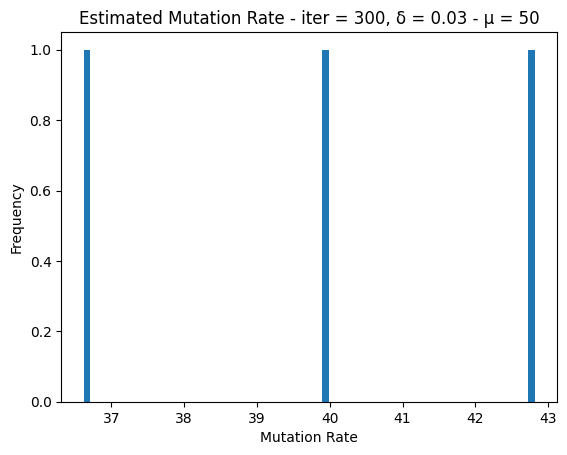

In [170]:
# Threshold 0.03 - 300 iterations - mu = 50 - range(10, 100)
plt.hist(params, bins=70)
plt.xlabel('Mutation Rate')
plt.ylabel('Frequency')
plt.title('Estimated Mutation Rate - iter = 300, δ = 0.03 - μ = 50')
plt.show()

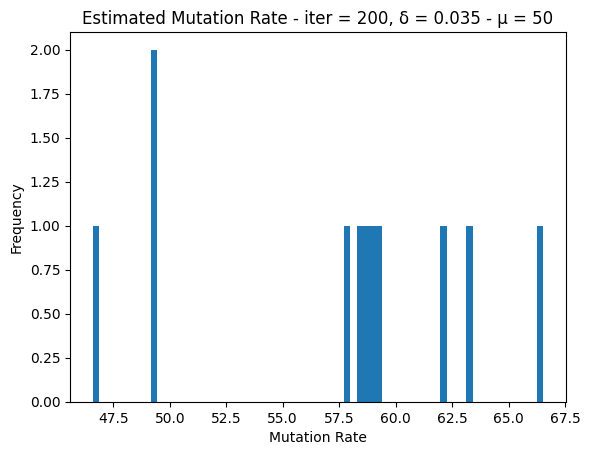

In [167]:
# Threshold 0.035 - 200 iterations
plt.hist(params, bins=70)
plt.xlabel('Mutation Rate')
plt.ylabel('Frequency')
plt.title('Estimated Mutation Rate - iter = 200, δ = 0.035 - μ = 50')
plt.show()

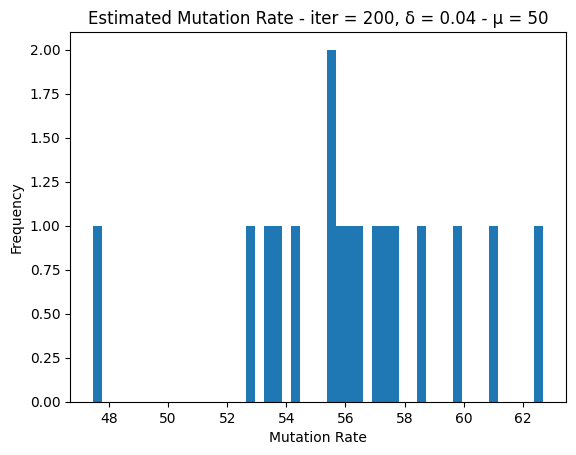

In [165]:
# Threshold 0.04 - 200 iterations
plt.hist(params, bins=50)
plt.xlabel('Mutation Rate')
plt.ylabel('Frequency')
plt.title('Estimated Mutation Rate - iter = 200, δ = 0.04 - μ = 50')
plt.show()

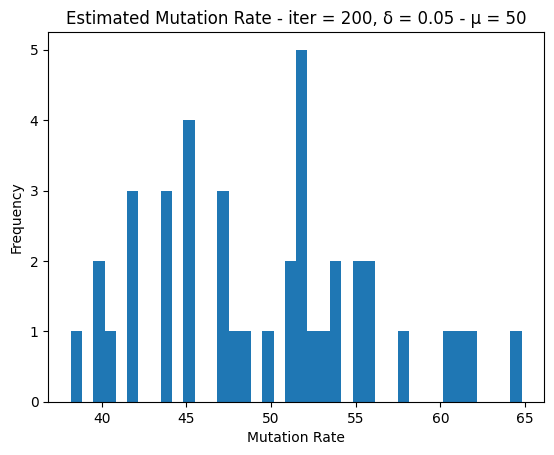

In [163]:
# Threshold 0.05 - 200 iterations - mu = 50 - range(10, 100)
plt.hist(params, bins=40)
plt.xlabel('Mutation Rate')
plt.ylabel('Frequency')
plt.title('Estimated Mutation Rate - iter = 200, δ = 0.05 - μ = 50')
plt.show()

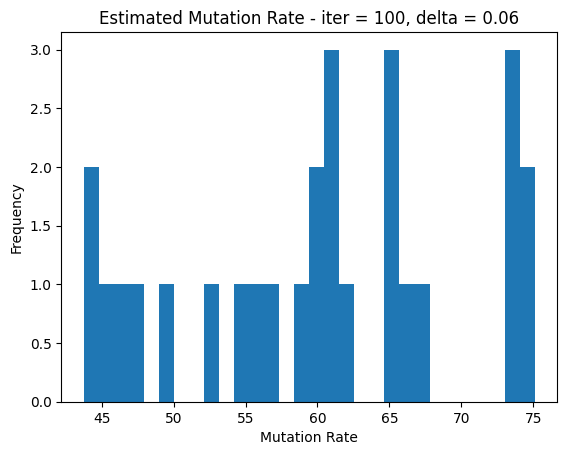

In [157]:
# Threshold 0.06 - 100 iterations - mu = 50 - range(10, 100)
plt.hist(params, bins=30)
plt.xlabel('Mutation Rate')
plt.ylabel('Frequency')
plt.title('Estimated Mutation Rate - iter = 100, delta = 0.06')
plt.show()

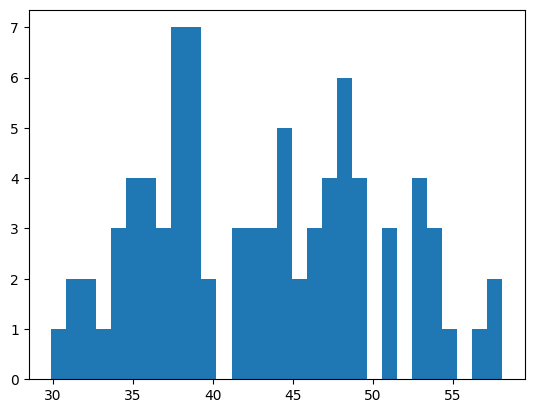

In [91]:
# Threshold 0.07 - 500 iterations
plt.hist(params, bins=30)
plt.xlabel('Mutation Rate')
plt.ylabel('Frequency')
plt.title('Estimated Mutation Rate - iter = 100, delta = 0.07')
plt.show()

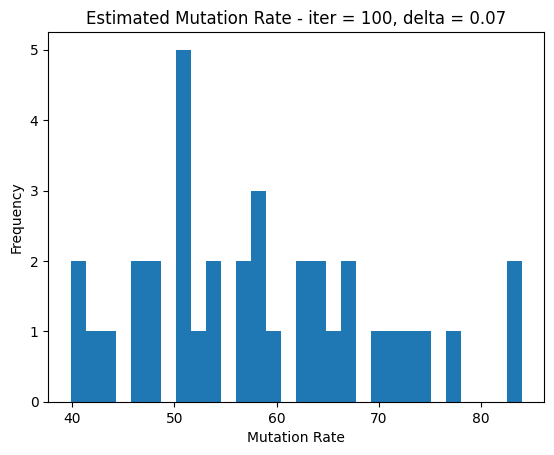

In [154]:
# Threshold 0.07 - 100 iterations - range(10, 100) - mu = 50
plt.hist(params, bins=30)
plt.xlabel('Mutation Rate')
plt.ylabel('Frequency')
plt.title('Estimated Mutation Rate - iter = 100, delta = 0.07')
plt.show()

In [149]:
target = vaf_simulator_neutral(initial_population, birth_rate, death_rate, 50, max_cells, initial_mutations, coverage, cutoff, ploidy)
obs_vaf_1 = vaf_simulator_neutral(initial_population, birth_rate, death_rate, 20, max_cells, initial_mutations, coverage, cutoff, ploidy)
obs_vaf_2 = vaf_simulator_neutral(initial_population, birth_rate, death_rate, 50, max_cells, initial_mutations, coverage, cutoff, ploidy)
obs_vaf_3 = vaf_simulator_neutral(initial_population, birth_rate, death_rate, 80, max_cells, initial_mutations, coverage, cutoff, ploidy)

In [150]:
stats.kstest(obs_vaf_1, target)

KstestResult(statistic=0.20231869887879353, pvalue=5.120293744216364e-51, statistic_location=0.32857142857142857, statistic_sign=-1)

In [151]:
stats.kstest(obs_vaf_2, target)

KstestResult(statistic=0.07051675272262091, pvalue=1.0470517209612881e-08, statistic_location=0.06829268292682927, statistic_sign=-1)

In [152]:
stats.kstest(obs_vaf_3, target)

KstestResult(statistic=0.09903348264336109, pvalue=2.8938095064872046e-19, statistic_location=0.16417910447761194, statistic_sign=1)

In [176]:
type(obs_vaf_1)

list

## ABC - SMC
Perform Approximate Bayesian Computation Sequential Monte Carlo using the package ``pyABC`` [https://github.com/icb-dcm/pyabc].

In [201]:
import pyabc
import os
import tempfile
from pyabc.sampler import SingleCoreSampler
pyabc.settings.set_figure_params('pyabc')  

In [203]:
def model(parameter):
    print("Running model with parameter:", parameter)
    initial_population = 1
    birth_rate = 10.0
    death_rate = 0.0
    max_cells = 10000
    initial_mutations = 1000
    coverage = 200
    cutoff = 0.02
    ploidy = 2
    
    parameter = parameter["mu"]
    
    obs_vaf = vaf_simulator_neutral(initial_population, birth_rate, death_rate, parameter, max_cells, initial_mutations, coverage, cutoff, ploidy)
    return {"data": np.array(obs_vaf)}

prior = pyabc.Distribution(mu=pyabc.RV("uniform", 10, 100))

def distance(x, x0):
    print("Calculating distance")
    return stats.kstest(x["data"], x0["data"])[0]

abc = pyabc.ABCSMC(model, prior, distance, population_size=1000, sampler=SingleCoreSampler())

db_path = os.path.join(tempfile.gettempdir(), "test.db")
observation = {"data": np.array(target)} 
abc.new("sqlite:///" + db_path, observation)

history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

ABC.History INFO: Start <ABCSMC id=10, start_time=2024-05-29 14:42:53>
ABC INFO: Calibration sample t = -1.


Running model with parameter: <Parameter 'mu': 106.98071315071579>
Running model with parameter: <Parameter 'mu': 11.421471165692578>
Running model with parameter: <Parameter 'mu': 80.89236437412151>
Running model with parameter: <Parameter 'mu': 105.28783655747687>
Running model with parameter: <Parameter 'mu': 95.74095360030124>
Running model with parameter: <Parameter 'mu': 34.77685780297902>
Running model with parameter: <Parameter 'mu': 102.7174648393913>
Running model with parameter: <Parameter 'mu': 47.06728952302325>
Running model with parameter: <Parameter 'mu': 50.34326523411629>
Running model with parameter: <Parameter 'mu': 101.73450186392125>
Running model with parameter: <Parameter 'mu': 45.895603871433536>
Running model with parameter: <Parameter 'mu': 39.533752465004085>
Running model with parameter: <Parameter 'mu': 24.550380515227257>
Running model with parameter: <Parameter 'mu': 31.817854227085178>
Running model with parameter: <Parameter 'mu': 43.090728622086644>
R